## Подготовка датасета для задачи детекции окон и дверей

In [1]:
pip install -U ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.7 MB/s eta 0:00:00:00:0100:01
Note: you may need 

In [2]:
! pip install torchmetrics torchvision -q

In [31]:
import os
from PIL import Image
from collections import Counter
import yaml
import shutil
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import json
import random
import cv2
from glob import glob
import torch

from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from ultralytics import YOLO

In [7]:
# представленные в датасете классы
base_path = '/kaggle/input/construction-plan'
with open(f'{base_path}/data.yaml', 'r') as f:
    data_y = yaml.safe_load(f)

names_dict = {i: name for i, name in enumerate(data_y['names'])}
print(names_dict)

{0: 'Door', 1: 'Window'}


In [8]:
# функция подсчета предлставленных классов по всем планам и вывода графика распредления
def count_yolo_classes(labels_dir, class_names=None, show_plot=True):
  class_counts = Counter()

  # обходим все .txt-файлы
  for filename in os.listdir(labels_dir):
    if filename.endswith('.txt'):
        with open(os.path.join(labels_dir, filename), 'r') as f:
            for line in f:
                parts = line.strip().split()
                if parts:  # если строка не пустая
                    class_id = parts[0]
                    class_counts[class_id] += 1

  for cls_id, count in class_counts.items():
    name = class_names.get(cls_id, f"Класс {cls_id}") if class_names else cls_id
    print(f"{name}: {count} объектов")

  if show_plot and class_counts:
        labels = [class_names.get(k, k) for k in class_counts.keys()]
        values = list(class_counts.values())

        plt.figure(figsize=(6, 4))
        plt.bar(labels, values, color=['skyblue', 'orange'])
        plt.title(f"Распределение классов в {os.path.basename(labels_dir)}")
        plt.xlabel("Классы")
        plt.ylabel("Количество объектов")
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()

  return class_counts

Window: 31801 объектов
Door: 32948 объектов


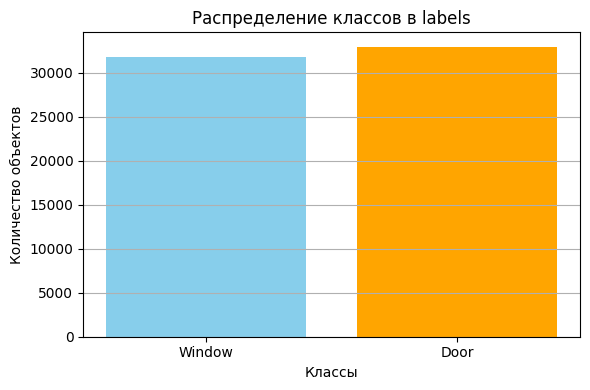

Counter({'1': 31801, '0': 32948})

In [9]:
class_names=class_names = {'0': data_y['names'][0], '1': data_y['names'][1]}
count_yolo_classes(f"{base_path}/train/labels", class_names)

In [10]:
# куда сохраним уменьшенный по трейну датасет
new_path = '/kaggle/working/dataset_reduced'

os.makedirs(f'{new_path}/train/images', exist_ok=True)
os.makedirs(f'{new_path}/train/labels', exist_ok=True)
os.makedirs(f'{new_path}/valid/images', exist_ok=True)
os.makedirs(f'{new_path}/valid/labels', exist_ok=True)
os.makedirs(f'{new_path}/test/images', exist_ok=True)
os.makedirs(f'{new_path}/test/labels', exist_ok=True)

In [12]:
# функция уменьшения датасета
def reduce_dataset(src_img_dir, src_lbl_dir, dst_img_dir, dst_lbl_dir,
                   num_samples, seed=None):
    all_images = [f for f in os.listdir(src_img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if seed is not None:
        random.seed(seed)

    sampled_images = random.sample(all_images, num_samples)

    for img_file in sampled_images:
        label_file = os.path.splitext(img_file)[0] + '.txt'

        shutil.copy(os.path.join(src_img_dir, img_file), os.path.join(dst_img_dir, img_file))
        shutil.copy(os.path.join(src_lbl_dir, label_file), os.path.join(dst_lbl_dir, label_file))

# уменьшаем только train до 800 примеров
reduce_dataset(
    src_img_dir=f'{base_path}/train/images',
    src_lbl_dir=f'{base_path}/train/labels',
    dst_img_dir=f'{new_path}/train/images',
    dst_lbl_dir=f'{new_path}/train/labels',
    num_samples=800,
    seed=42
)

# копируем valid и test без изменений
for split in ['valid', 'test']:
    shutil.copytree(f'{base_path}/{split}/images', f'{new_path}/{split}/images',
                    dirs_exist_ok=True)
    shutil.copytree(f'{base_path}/{split}/labels', f'{new_path}/{split}/labels',
                    dirs_exist_ok=True)

In [13]:
# функция удаления пустых аннотаций
def remove_empty_annotations(labels_dir, images_dir, image_extensions=['.jpg', '.jpeg', '.png']):
  deleted = 0
  for file in os.listdir(labels_dir):
    label_path = os.path.join(labels_dir, file)
    # проверка: файл существует и пустой
    if os.path.getsize(label_path) == 0:
        base_name = os.path.splitext(file)[0]

        # найти и удалить изображение с тем же именем
        for ext in image_extensions:
            img_path = os.path.join(images_dir, base_name + ext)
            if os.path.exists(img_path):
                os.remove(img_path)
                break

        os.remove(label_path)
        deleted += 1

  print(f"✅ Всего удалено: {deleted} пар (аннотация + изображение)")

In [14]:
# удаление из train
remove_empty_annotations('/kaggle/working/dataset_reduced/train/labels',
                         '/kaggle/working/dataset_reduced/train/images')

✅ Всего удалено: 2 пар (аннотация + изображение)


In [15]:
# удаление из valid
remove_empty_annotations('/kaggle/working/dataset_reduced/valid/labels', 
                         '/kaggle/working/dataset_reduced/valid/images')

✅ Всего удалено: 9 пар (аннотация + изображение)


In [16]:
# удаление из test
remove_empty_annotations('/kaggle/working/dataset_reduced/test/labels',
                         '/kaggle/working/dataset_reduced/test/images')

✅ Всего удалено: 0 пар (аннотация + изображение)


In [17]:
# формируем новый .yaml файл
data_yaml = {
    'train': f'{new_path}/train/images',
    'val': f'{new_path}/valid/images',
    'test': f'{new_path}/test/images',
    'nc': 2,
    'names': ['Door', 'Window'],
}

yaml_path_ = f'{new_path}/data.yaml'
with open(yaml_path_, 'w') as f:
    yaml.dump(data_yaml, f)

Класс 1: 6803 объектов
Класс 0: 7066 объектов


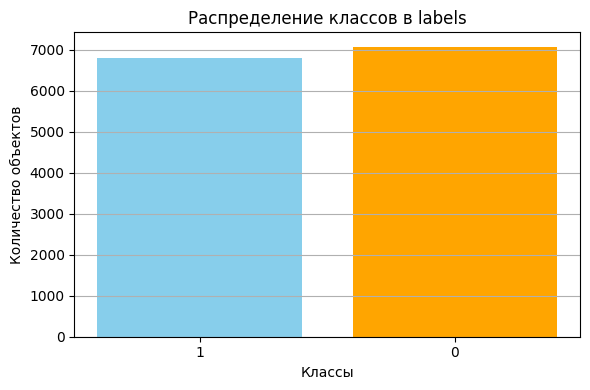

Counter({'1': 6803, '0': 7066})

In [18]:
# распределение классов по train в уменьшенном датасете
count_yolo_classes(f"{new_path}/train/labels", names_dict)

## Обучение модели детекции 2-х классов

In [ ]:
# запускаем обучение модели
model = YOLO('yolov8m.pt')

model.train(
    data=yaml_path_,
    epochs=70,
    imgsz=800,
    batch=16,
    name='yolov8_doors_windows',
    workers=4,
    exist_ok=True,
    cache=True,
    seed=42,
    degrees=0.3, translate=0.2, scale=0.7, flipud=0.5
)

Ultralytics 8.3.162 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset_reduced/data.yaml, degrees=0.3, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=800, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_doors_windows, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=T

train: Scanning /kaggle/working/dataset_reduced/train/labels... 800 images, 0 backgrounds, 0 corrupt: 100%|██████████| 800/800 [00:00<00:00, 1346.38it/s]

train: /kaggle/working/dataset_reduced/train/images/image_3888_png.rf.85b3127c8a090f724fd6a4f315c078e6.jpg: 1 duplicate labels removed
train: /kaggle/working/dataset_reduced/train/images/image_419_png.rf.4e7ba6893ff7dd5eb523f89c25349f60.jpg: 1 duplicate labels removed
train: /kaggle/working/dataset_reduced/train/images/image_4429_png.rf.761ada8f665114ee38e041537f446e8d.jpg: 1 duplicate labels removed
train: /kaggle/working/dataset_reduced/train/images/image_663_png.rf.7af470d4ecf1af721ae36b79d24ee93a.jpg: 1 duplicate labels removed


train: New cache created: /kaggle/working/dataset_reduced/train/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (1.4GB RAM): 100%|██████████| 800/800 [00:01<00:00, 587.52it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 396.0±237.4 MB/s, size: 67.1 KB)


val: Scanning /kaggle/working/dataset_reduced/valid/labels... 1132 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1132/1132 [00:00<00:00, 1188.98it/s]

val: /kaggle/working/dataset_reduced/valid/images/image_1353_png.rf.d3a6ae138e40076995b3d51f12835745.jpg: 1 duplicate labels removed
val: /kaggle/working/dataset_reduced/valid/images/image_4180_png.rf.9520283ae43cecc7d5b4138897ee9d64.jpg: 1 duplicate labels removed
val: /kaggle/working/dataset_reduced/valid/images/image_4700_png.rf.0945d324477bed08e8345566dcebdf8f.jpg: 1 duplicate labels removed
val: New cache created: /kaggle/working/dataset_reduced/valid/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (2.0GB RAM): 100%|██████████| 1132/1132 [00:02<00:00, 562.24it/s]


Plotting labels to runs/detect/yolov8_doors_windows/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 800 train, 800 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8_doors_windows
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70      10.1G        1.6       1.93      1.225        372        800: 100%|██████████| 50/50 [00:40<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:26<00:00,  1.37it/s]


                   all       1132      20200      0.402      0.609      0.349      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70      9.53G      1.315      1.096      1.091        457        800: 100%|██████████| 50/50 [00:42<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:24<00:00,  1.49it/s]


                   all       1132      20200      0.282      0.657      0.241      0.143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70      9.75G      1.306       1.05      1.093        394        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:24<00:00,  1.49it/s]


                   all       1132      20200      0.669      0.654      0.655      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70      9.53G      1.275     0.9994      1.076        447        800: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:24<00:00,  1.49it/s]


                   all       1132      20200      0.719      0.713      0.722       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70      9.65G      1.253     0.9801       1.07        371        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.50it/s]


                   all       1132      20200      0.736      0.738      0.754      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70      9.84G      1.213     0.9177      1.052        474        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:24<00:00,  1.48it/s]


                   all       1132      20200      0.731      0.722      0.744      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70      9.69G      1.181     0.8843      1.039        417        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.746      0.738      0.751      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70      9.55G      1.187     0.8851      1.039        474        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]


                   all       1132      20200      0.745      0.741       0.77      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70      9.68G      1.184     0.8713      1.041        349        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]

                   all       1132      20200      0.777      0.768      0.798      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70        10G      1.153     0.8543      1.028        509        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.767      0.778      0.805      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70      9.48G      1.141     0.8155      1.016        314        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]

                   all       1132      20200      0.769      0.765      0.794      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70      9.55G      1.117     0.8133      1.008        341        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.781      0.778      0.814      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70      9.79G      1.112      0.809      1.013        494        800: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]

                   all       1132      20200       0.78      0.784      0.814      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70      9.52G        1.1     0.8147      1.019        366        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]

                   all       1132      20200      0.781      0.792      0.824       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70      9.68G      1.094     0.7776     0.9973        371        800: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]

                   all       1132      20200      0.774      0.799      0.816      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70      9.91G      1.091     0.7743     0.9957        376        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]

                   all       1132      20200      0.792      0.796      0.827      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70      9.84G      1.089     0.7664     0.9917        280        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]

                   all       1132      20200      0.801      0.798      0.835      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70      9.95G      1.078     0.7676     0.9953        404        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]

                   all       1132      20200      0.802      0.803      0.835      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70      9.58G      1.077     0.7703     0.9955        354        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.796      0.787      0.827      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70      9.81G      1.069      0.756     0.9977        427        800: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]

                   all       1132      20200      0.793      0.785      0.821      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70      9.79G       1.08     0.7541     0.9883        458        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]


                   all       1132      20200      0.789      0.809      0.837      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70      9.62G      1.076     0.7278     0.9813        426        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]


                   all       1132      20200      0.777      0.786      0.818      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70       9.8G      1.034     0.7083     0.9736        312        800: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.809      0.801      0.851       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70      9.58G      1.054     0.7347     0.9827        266        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]

                   all       1132      20200      0.798      0.788      0.824      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70      9.79G       1.05     0.7367     0.9783        517        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.801      0.808      0.843      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70      9.68G      1.046     0.7153     0.9751        375        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]

                   all       1132      20200      0.806      0.809      0.846      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70      9.75G      1.029     0.7271     0.9849        309        800: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]

                   all       1132      20200      0.807       0.82      0.851      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70      9.87G      1.006     0.6983     0.9663        376        800: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.801      0.818      0.846      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70      10.1G      1.024     0.6958     0.9686        352        800: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200        0.8      0.828      0.852      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70      9.75G      1.021     0.6941     0.9682        314        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.796      0.814      0.843      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70      9.77G       1.02     0.7099     0.9681        481        800: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]

                   all       1132      20200       0.79      0.807      0.834      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70      9.62G      1.025     0.7002     0.9683        290        800: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.821      0.815      0.858      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70      9.73G      1.023     0.6935     0.9777        338        800: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]

                   all       1132      20200      0.787      0.777       0.83      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70      9.64G      1.009     0.6857     0.9575        475        800: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]

                   all       1132      20200      0.818      0.819      0.854      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70      9.66G     0.9825     0.6735     0.9708        221        800: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]

                   all       1132      20200      0.811      0.822      0.852      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70      9.51G     0.9993     0.6726     0.9566        400        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.825      0.808      0.857      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70      10.2G       1.01     0.6713     0.9647        385        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.819      0.824      0.865      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70      9.47G     0.9839     0.6601     0.9592        479        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.815      0.835      0.861      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70      9.76G     0.9732     0.6471     0.9528        306        800: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.835      0.823      0.866      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70      9.79G      0.993     0.6584     0.9548        399        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.806      0.814      0.848       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70      9.76G     0.9711     0.6415      0.946        384        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200       0.83      0.826      0.865       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/70       9.8G     0.9617     0.6339     0.9493        313        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]

                   all       1132      20200       0.81      0.831      0.857      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/70      9.79G     0.9667      0.639     0.9625        310        800: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200       0.84      0.824      0.872      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/70      9.66G     0.9687     0.6407      0.952        221        800: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]

                   all       1132      20200      0.827      0.829      0.871      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/70      9.57G     0.9618     0.6391     0.9512        292        800: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]

                   all       1132      20200      0.831      0.834      0.872      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/70      9.67G     0.9667     0.6325     0.9456        440        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.826      0.825      0.864      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/70      9.65G     0.9481     0.6215     0.9429        535        800: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]

                   all       1132      20200      0.839      0.831      0.873      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/70      9.64G     0.9601     0.6229     0.9429        510        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.825       0.84      0.871      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/70      9.69G     0.9469     0.6124      0.946        384        800: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.838      0.824      0.867      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/70      9.71G     0.9434      0.608     0.9411        365        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.839      0.831      0.875      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/70      9.86G     0.9546     0.6177     0.9451        347        800: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]

                   all       1132      20200      0.834      0.831      0.872      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/70      9.89G     0.9625      0.614     0.9489        284        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.832      0.834      0.869      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/70      9.93G     0.9373     0.5893     0.9375        286        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]

                   all       1132      20200      0.846      0.833      0.879      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/70        10G      0.935     0.5972     0.9363        365        800: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.841      0.831      0.872      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/70      9.43G     0.9362      0.593     0.9302        486        800: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.839      0.837      0.879      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/70        10G     0.9176     0.5874     0.9304        448        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]

                   all       1132      20200      0.834      0.842      0.878      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/70      9.95G     0.9359     0.5827     0.9387        312        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.839      0.843      0.879      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/70      9.44G     0.9281     0.5875     0.9349        317        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.836      0.844      0.877      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/70        10G     0.9149      0.569     0.9275        380        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.844      0.837      0.875      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/70      9.67G     0.9159      0.588     0.9269        343        800: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200       0.85      0.836      0.881      0.631


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/70      9.45G     0.8766      0.558     0.9531        235        800: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]

                   all       1132      20200      0.836      0.838      0.873      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/70      9.42G     0.8794      0.551     0.9542        244        800: 100%|██████████| 50/50 [00:40<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.848      0.834      0.883       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/70      9.42G     0.8659     0.5451     0.9516        212        800: 100%|██████████| 50/50 [00:40<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200       0.85      0.841      0.886      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/70      9.38G     0.8504     0.5341     0.9441        292        800: 100%|██████████| 50/50 [00:40<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.851      0.839      0.884      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/70      9.46G     0.8543     0.5336     0.9504        238        800: 100%|██████████| 50/50 [00:40<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.863      0.833      0.885      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/70      9.34G     0.8655     0.5272     0.9579        261        800: 100%|██████████| 50/50 [00:40<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.851      0.841      0.885      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/70       9.5G     0.8552     0.5292     0.9456        245        800: 100%|██████████| 50/50 [00:40<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.848      0.847      0.885      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/70      9.52G       0.85     0.5284     0.9431        264        800: 100%|██████████| 50/50 [00:40<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.852      0.843      0.887      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/70      9.47G     0.8393     0.5167     0.9394        154        800: 100%|██████████| 50/50 [00:40<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.846      0.849      0.888      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/70      9.42G     0.8442     0.5149     0.9395        333        800: 100%|██████████| 50/50 [00:40<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

                   all       1132      20200      0.854      0.843      0.888       0.64



70 epochs completed in 1.295 hours.
Optimizer stripped from runs/detect/yolov8_doors_windows/weights/last.pt, 52.1MB
Optimizer stripped from runs/detect/yolov8_doors_windows/weights/best.pt, 52.1MB

Validating runs/detect/yolov8_doors_windows/weights/best.pt...
Ultralytics 8.3.162 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:24<00:00,  1.48it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1132      20200      0.854      0.843      0.888       0.64
                  Door       1117      10209      0.889      0.926      0.943      0.757
                Window       1121       9991      0.818       0.76      0.832      0.523
Speed: 0.3ms preprocess, 15.6ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/yolov8_doors_windows


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b6248455e90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

## Проверка на валидационной выборке и вывод матрицы ошибок

In [ ]:
model = YOLO('/kaggle/working/runs/detect/yolov8_doors_windows/weights/best.pt')
metrics = model.val()
print('mAP50:', metrics.box.map50)
print('mAP50-95:', metrics.box.map)

Ultralytics 8.3.162 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1320.1±835.3 MB/s, size: 80.4 KB)


val: Scanning /kaggle/working/dataset_reduced/valid/labels.cache... 1132 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1132/1132 [00:00<?, ?it/s]

val: /kaggle/working/dataset_reduced/valid/images/image_1353_png.rf.d3a6ae138e40076995b3d51f12835745.jpg: 1 duplicate labels removed
val: /kaggle/working/dataset_reduced/valid/images/image_4180_png.rf.9520283ae43cecc7d5b4138897ee9d64.jpg: 1 duplicate labels removed
val: /kaggle/working/dataset_reduced/valid/images/image_4700_png.rf.0945d324477bed08e8345566dcebdf8f.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 71/71 [00:45<00:00,  1.56it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1132      20200      0.854      0.843      0.888      0.643
                  Door       1117      10209      0.889      0.927      0.943      0.759
                Window       1121       9991       0.82       0.76      0.833      0.527
Speed: 0.8ms preprocess, 34.9ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val
mAP50: 0.8882290376395392
mAP50-95: 0.6432379095696545


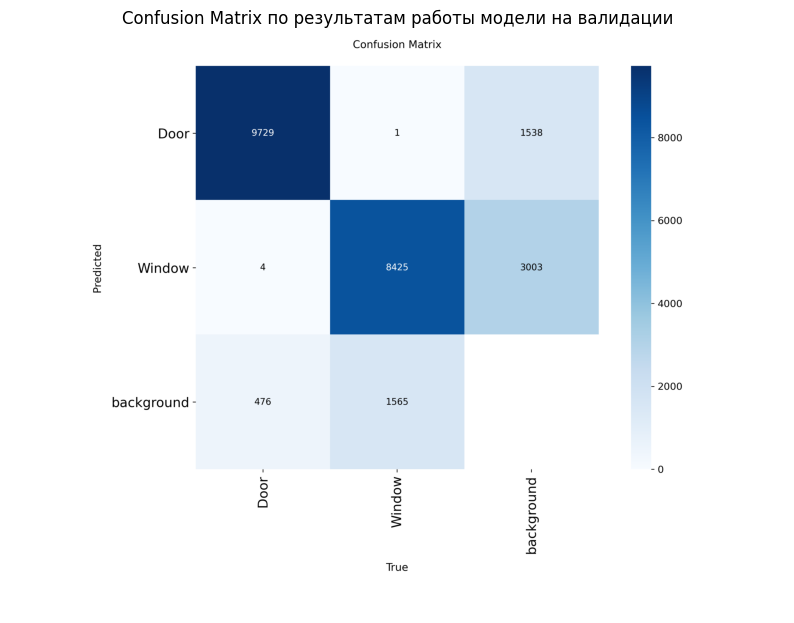

In [ ]:
img = mpimg.imread('/kaggle/working/runs/detect/yolov8_doors_windows/confusion_matrix.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title('Confusion Matrix по результатам работы модели на валидации')
plt.show()

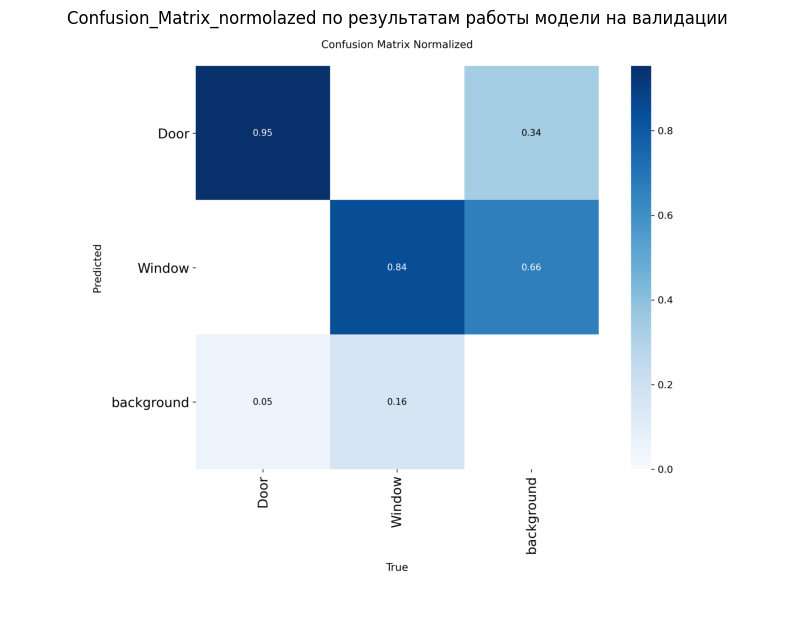

In [ ]:
img_2 = mpimg.imread(
    '/kaggle/working/runs/detect/yolov8_doors_windows/confusion_matrix_normalized.png')
plt.figure(figsize=(10, 10))
plt.imshow(img_2)
plt.axis('off')
plt.title('Confusion_Matrix_normolazed по результатам работы модели на валидации')
plt.show()

## Предсказания  на тестовой выборке и расчет метрик качества mAP50 и mAP50-95

In [ ]:
results = model.predict(source=f'{new_path}/test/images', save=True, conf=0.25)


image 1/516 /kaggle/working/dataset_reduced/test/images/1735142708550_4_jpg.rf.31b91c7794faa6e863d7cbacc8d67eb0.jpg: 800x800 2 Doors, 3 Windows, 58.8ms
image 2/516 /kaggle/working/dataset_reduced/test/images/1735142882118_2_jpg.rf.307978eea2d125d3fa58f1d72f526e46.jpg: 800x800 2 Doors, 2 Windows, 58.7ms
image 3/516 /kaggle/working/dataset_reduced/test/images/1735143985099_3_jpg.rf.232574d880c46674d1f3f1db543484e1.jpg: 800x800 7 Doors, 3 Windows, 44.9ms
image 4/516 /kaggle/working/dataset_reduced/test/images/1735627489299-Cropped-1_jpg.rf.405b6ff915f35362dc80adf7c7cddb7e.jpg: 800x800 6 Doors, 2 Windows, 39.7ms
image 5/516 /kaggle/working/dataset_reduced/test/images/1735628217481-Cropped-1_jpg.rf.2886b36774d3f1b677c02f77a5986c2f.jpg: 800x800 2 Doors, 2 Windows, 38.9ms
image 6/516 /kaggle/working/dataset_reduced/test/images/1735635573410_1_jpg.rf.99bdaf859cbc462d8d61dad74dbbd2b4.jpg: 800x800 3 Doors, 2 Windows, 38.3ms
image 7/516 /kaggle/working/dataset_reduced/test/images/1735675948559_4

In [ ]:
# функция преобразования координат в абсолютный формат с PyTorch-тензорами
def load_gt_yolo_format(image_path, label_dir):
    img = cv2.imread(image_path)
    h, w = img.shape[:2]
    image_name = os.path.basename(image_path)
    label_file = os.path.join(label_dir, image_name.replace('.jpg', '.txt').replace('.png', '.txt'))

    boxes = []
    labels = []

    if os.path.exists(label_file):
        with open(label_file, 'r') as f:
            for line in f.readlines():
                cls, x_c, y_c, width, height = map(float, line.strip().split())
                
                x1 = (x_c - width / 2) * w
                y1 = (y_c - height / 2) * h
                x2 = (x_c + width / 2) * w
                y2 = (y_c + height / 2) * h

                boxes.append([x1, y1, x2, y2])
                labels.append(int(cls))
    else:
        boxes = []
        labels = []

    return {
        "boxes": torch.tensor(boxes, dtype=torch.float32),
        "labels": torch.tensor(labels, dtype=torch.int64)
    }

In [ ]:
# преобразовываем тестовые данные и сохраняем в targets
image_dir = "/kaggle/working/dataset_reduced/test/images"
label_dir = "/kaggle/working/dataset_reduced/test/labels"

image_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))

targets = []

for img_path in image_paths:
    target = load_gt_yolo_format(img_path, label_dir)
    targets.append(target)

In [ ]:
# преобразовываем предсказания на тесте и сохраняем в preds
preds = []

for result in results:
    boxes = result.boxes

    # проверка, есть ли вообще объекты
    if boxes is not None and boxes.cls.nelement() > 0:
        pred_dict = {
            "boxes": boxes.xyxy.cpu(),         
            "scores": boxes.conf.cpu(),        
            "labels": boxes.cls.int().cpu()
        }
    # если объектов не обнаружено
    else:
        pred_dict = {
            "boxes": torch.empty((0, 4), dtype=torch.float32),
            "scores": torch.empty((0,), dtype=torch.float32),
            "labels": torch.empty((0,), dtype=torch.int64)
        }

    preds.append(pred_dict)

In [ ]:
# считаем метрику качества MeanAveragePrecision
metric = MeanAveragePrecision(iou_type="bbox")
metric.update(preds, targets)
metrics = metric.compute()

print("mAP@0.5:", metrics["map_50"])
print("mAP@0.5:0.95:", metrics["map"])

mAP@0.5: tensor(0.8428)
mAP@0.5:0.95: tensor(0.6215)


## Подготовка датасета для задачи классифкации помещений

In [6]:
# выводим информацию по классам помещений в датасете
input_path = '/kaggle/input/estima-dataset/Estima_ai.v3i.yolov8'
output_path = '/kaggle/working/estima-rooms'

with open(f'{input_path}/data.yaml', 'r') as f:
    data_yaml = yaml.safe_load(f)

id_names_dict = {i: name for i, name in enumerate(data_yaml['names'])}
print(id_names_dict)

{0: 'Balcony', 1: 'Bathroom', 2: 'Bedroom', 3: 'Closet', 4: 'Diningroom', 5: 'Garage', 6: 'Hall', 7: 'Kitchen', 8: 'Livingroom', 9: 'Mech', 10: 'Office', 11: 'Other', 12: 'Patio', 13: 'Staircase', 14: 'Toilet', 15: 'WD'}


In [7]:
# функция подготовки геометрических признаков для каждой комнаты
def parse_label_file(label_path):
    objects = []
    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            cls_id = int(parts[0])
            coords = list(map(float, parts[1:]))
            if len(coords) % 2 != 0:
                continue
            polygon = np.array(coords).reshape(-1, 2)
            objects.append((cls_id, polygon))
    return objects

In [8]:
# классы, которые объединяем в 'Other'
rename_classes = {'Mech', 'Office', 'Patio', 'Staircase', 'WD'}
map_class= {cls: 'Other' if cls in rename_classes else cls for cls in data_yaml['names']}
class_id_map = {i: map_class[cls] for i, cls in enumerate(data_yaml['names'])}

In [9]:
# функция создания изображений для отдельных помещений
def save_crop(image, polygon, save_path, min_area=20, min_size=5):
    h, w = image.shape[:2]

    # преобразуем нормализованные координаты в пиксели
    pts = np.array(polygon, dtype=np.float32).reshape(-1, 2)
    pts[:, 0] *= w
    pts[:, 1] *= h
    pts = pts.astype(np.int32)

    # валидный ли полигон
    if pts.shape[0] < 3:
        print(f"!!! Недостаточно точек: {save_path}")
        return

    # проверка площади
    area = cv2.contourArea(pts)
    if area < min_area:
        print(f"!!! Площадь полигона < {min_area}px²: {area:.2f} — {save_path}")
        return

    # создание маски
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.fillPoly(mask, [pts], 255)

    # применение маски
    crop_masked = cv2.bitwise_and(image, image, mask=mask)

    # получаем bounding box
    x, y, bw, bh = cv2.boundingRect(pts)
    x2 = min(w, x + bw)
    y2 = min(h, y + bh)
    x = max(0, x)
    y = max(0, y)

    # проверка размеров
    if x2 - x < min_size or y2 - y < min_size:
        print(f"!!! Кроп слишком мал: ({x2 - x}px × {y2 - y}px) — {save_path}")
        return

    # обрезаем финальный кроп
    crop = crop_masked[y:y2, x:x2]

    if crop is None or crop.size == 0:
        print(f"!!! Пустой кроп: {save_path}")
        return

    # сохраняем
    Path(save_path).parent.mkdir(parents=True, exist_ok=True)
    # сохраняем
    cv2.imwrite(str(save_path), crop)

In [10]:
img_exts = ('.jpg', '.png', '.jpeg')

In [11]:
# функция разделения датасета по типам помещения
def process_split(split):
    image_dir = os.path.join(input_path, split, 'images')
    label_dir = os.path.join(input_path, split, 'labels')
    output_dir = os.path.join(output_path, split)

    os.makedirs(output_dir, exist_ok=True)

    for fname in tqdm(os.listdir(image_dir)):
        if not fname.lower().endswith(img_exts):
            continue
        img_path = os.path.join(image_dir, fname)
        label_path = os.path.join(label_dir, Path(fname).with_suffix('.txt'))

        if not os.path.exists(label_path):
            continue

        image = cv2.imread(img_path)
        if image is None:
            continue

        objects = parse_label_file(label_path)
        for idx, (cls_id, polygon) in enumerate(objects):
            cls_name = class_id_map[cls_id]
            class_folder = os.path.join(output_dir, cls_name)
            os.makedirs(class_folder, exist_ok=True)

            save_name = f"{Path(fname).stem}_{idx}.jpg"
            save_crop(image, polygon, os.path.join(class_folder, save_name))

In [12]:
# разделяем датасет по типам помещения для модели классификации
process_split('train')
process_split('test')
process_split('val')

 12%|█▏        | 242/2065 [00:06<00:39, 46.13it/s]

!!! Площадь полигона < 20px²: 0.00 — /kaggle/working/estima-rooms/train/Livingroom/BIOTECH-Offices-Whse-set-PDFs_page-0005_jpg.rf.8a09220b28b74377894ab3a3c13289fb_7.jpg


100%|██████████| 266/266 [00:06<00:00, 42.12it/s]


## Обучение модели классификации

In [14]:
# запуск обучения модели классификации помещений
model = YOLO('yolov8s-cls.pt')

results = model.train(data="/kaggle/working/estima-rooms", epochs=50, patience=25,
                      imgsz=224, batch=16)

Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/estima-rooms, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=25, perspective=0.0, plots=True, pose=12.0, pretra

100%|██████████| 5.35M/5.35M [00:00<00:00, 76.1MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 350.0±333.2 MB/s, size: 10.4 KB)


train: Scanning /kaggle/working/estima-rooms/train... 16374 images, 23 corrupt: 100%|██████████| 16397/16397 [00:05<00:00, 3039.39it/s]

train: /kaggle/working/estima-rooms/train/Other/124951_jpg.rf.3df8e42605b6e28bb61ef8663cc2f804_20.jpg: ignoring corrupt image/label: image size (8, 21) <10 pixels
train: /kaggle/working/estima-rooms/train/Other/124951_jpg.rf.3df8e42605b6e28bb61ef8663cc2f804_21.jpg: ignoring corrupt image/label: image size (9, 18) <10 pixels
train: /kaggle/working/estima-rooms/train/Other/124951_jpg.rf.f384968db54199ddc408a9606ab8f002_20.jpg: ignoring corrupt image/label: image size (8, 21) <10 pixels
train: /kaggle/working/estima-rooms/train/Other/124951_jpg.rf.f384968db54199ddc408a9606ab8f002_21.jpg: ignoring corrupt image/label: image size (9, 18) <10 pixels
train: /kaggle/working/estima-rooms/train/Other/12_png_jpg.rf.b3640dccb1aa5e6bcfb01bef42cfa433_56.jpg: ignoring corrupt image/label: image size (12, 8) <10 pixels
train: /kaggle/working/estima-rooms/train/Other/12_png_jpg.rf.b3640dccb1aa5e6bcfb01bef42cfa433_77.jpg: ignoring corrupt image/label: image size (21, 9) <10 pixels
train: /kaggle/working

train: New cache created: /kaggle/working/estima-rooms/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 660.5±650.9 MB/s, size: 27.4 KB)


val: Scanning /kaggle/working/estima-rooms/val... 1934 images, 4 corrupt: 100%|██████████| 1938/1938 [00:00<00:00, 2938.90it/s]

val: /kaggle/working/estima-rooms/val/Other/17-Sale-Street_page-0001_jpg.rf.33683ffba177d35f10b2382f239982ea_12.jpg: ignoring corrupt image/label: image size (9, 26) <10 pixels
val: /kaggle/working/estima-rooms/val/Other/17-Sale-Street_page-0001_jpg.rf.33683ffba177d35f10b2382f239982ea_19.jpg: ignoring corrupt image/label: image size (9, 26) <10 pixels
val: /kaggle/working/estima-rooms/val/Other/17-Sale-Street_page-0001_jpg.rf.5737954a8bc42d084195f16b53cabbd9_12.jpg: ignoring corrupt image/label: image size (26, 9) <10 pixels
val: /kaggle/working/estima-rooms/val/Other/17-Sale-Street_page-0001_jpg.rf.5737954a8bc42d084195f16b53cabbd9_19.jpg: ignoring corrupt image/label: image size (26, 9) <10 pixels
val: New cache created: /kaggle/working/estima-rooms/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/train2
Starting training for 50 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/50     0.434G      2.308         16        224:   0%|          | 3/1024 [00:00<03:08,  5.42it/s]

       1/50     0.434G      2.329         16        224:   1%|          | 11/1024 [00:01<01:03, 16.02it/s]
100%|██████████| 755k/755k [00:00<00:00, 17.6MB/s]  224:   1%|          | 11/1024 [00:01<01:03, 16.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 16.61it/s]

                   all      0.673      0.972



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 16.49it/s]

                   all       0.64      0.973



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 17.22it/s]

                   all      0.683      0.973



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 16.87it/s]

                   all       0.72      0.982



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 17.18it/s]

                   all      0.706      0.985



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 17.17it/s]

                   all      0.726      0.987



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 16.79it/s]

                   all      0.725       0.99



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 16.69it/s]

                   all      0.748      0.991



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 17.04it/s]

                   all      0.737       0.99



      Epoch    GPU_mem       loss  Instances       Size


      10/50     0.596G     0.7219          6        224: 100%|██████████| 1024/1024 [00:55<00:00, 18.42it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 17.21it/s]

                   all      0.746      0.987



      Epoch    GPU_mem       loss  Instances       Size


      11/50     0.623G      0.708          6        224: 100%|██████████| 1024/1024 [00:54<00:00, 18.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 16.97it/s]

                   all      0.749       0.99



      Epoch    GPU_mem       loss  Instances       Size


      12/50     0.631G     0.6894          6        224: 100%|██████████| 1024/1024 [00:55<00:00, 18.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 16.56it/s]

                   all      0.746      0.989



      Epoch    GPU_mem       loss  Instances       Size


      13/50     0.658G     0.6697          6        224: 100%|██████████| 1024/1024 [00:56<00:00, 18.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 16.85it/s]

                   all      0.737       0.99



      Epoch    GPU_mem       loss  Instances       Size


      14/50     0.686G     0.6629          6        224: 100%|██████████| 1024/1024 [00:54<00:00, 18.70it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 16.79it/s]

                   all      0.754      0.991



      Epoch    GPU_mem       loss  Instances       Size


      15/50     0.695G      0.649          6        224: 100%|██████████| 1024/1024 [00:55<00:00, 18.57it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 16.95it/s]

                   all      0.754      0.989



      Epoch    GPU_mem       loss  Instances       Size


      16/50     0.721G     0.6362          6        224: 100%|██████████| 1024/1024 [00:55<00:00, 18.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 16.56it/s]

                   all      0.758      0.992



      Epoch    GPU_mem       loss  Instances       Size


      17/50      0.75G     0.6181          6        224: 100%|██████████| 1024/1024 [00:54<00:00, 18.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 17.17it/s]

                   all      0.758      0.988



      Epoch    GPU_mem       loss  Instances       Size


      18/50     0.758G     0.6125          6        224: 100%|██████████| 1024/1024 [00:54<00:00, 18.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 16.88it/s]

                   all      0.766       0.99



      Epoch    GPU_mem       loss  Instances       Size


      19/50     0.783G     0.5994          6        224: 100%|██████████| 1024/1024 [00:54<00:00, 18.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:04<00:00, 15.17it/s]

                   all      0.772      0.991



      Epoch    GPU_mem       loss  Instances       Size


      20/50     0.791G       0.59          6        224: 100%|██████████| 1024/1024 [00:54<00:00, 18.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 17.12it/s]

                   all      0.765      0.992



      Epoch    GPU_mem       loss  Instances       Size


      21/50     0.818G     0.5753          6        224: 100%|██████████| 1024/1024 [00:54<00:00, 18.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 16.92it/s]

                   all      0.775      0.991



      Epoch    GPU_mem       loss  Instances       Size


      22/50     0.848G      0.565          6        224: 100%|██████████| 1024/1024 [00:55<00:00, 18.56it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 17.10it/s]

                   all      0.782      0.988



      Epoch    GPU_mem       loss  Instances       Size


      23/50     0.855G     0.5623          6        224: 100%|██████████| 1024/1024 [00:55<00:00, 18.46it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 17.22it/s]

                   all      0.763       0.99



      Epoch    GPU_mem       loss  Instances       Size


      24/50     0.883G     0.5423          6        224: 100%|██████████| 1024/1024 [00:55<00:00, 18.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 16.61it/s]

                   all      0.777      0.988



      Epoch    GPU_mem       loss  Instances       Size


      25/50     0.891G     0.5411          6        224: 100%|██████████| 1024/1024 [00:53<00:00, 18.97it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 17.11it/s]

                   all      0.766       0.99



      Epoch    GPU_mem       loss  Instances       Size


      26/50     0.916G     0.5337          6        224: 100%|██████████| 1024/1024 [00:54<00:00, 18.79it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 17.38it/s]

                   all      0.774      0.988



      Epoch    GPU_mem       loss  Instances       Size


      27/50     0.943G     0.5248          6        224: 100%|██████████| 1024/1024 [00:54<00:00, 18.71it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 17.09it/s]

                   all       0.77      0.989



      Epoch    GPU_mem       loss  Instances       Size


      28/50     0.953G     0.5046          6        224: 100%|██████████| 1024/1024 [00:54<00:00, 18.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 16.78it/s]

                   all      0.766      0.991



      Epoch    GPU_mem       loss  Instances       Size


      29/50     0.979G      0.503          6        224: 100%|██████████| 1024/1024 [00:54<00:00, 18.74it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 15.64it/s]

                   all      0.774      0.991



      Epoch    GPU_mem       loss  Instances       Size


      30/50      1.01G     0.4985          6        224: 100%|██████████| 1024/1024 [00:54<00:00, 18.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 17.00it/s]

                   all      0.768      0.989



      Epoch    GPU_mem       loss  Instances       Size


      31/50      1.01G     0.4847          6        224: 100%|██████████| 1024/1024 [00:54<00:00, 18.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 16.83it/s]

                   all      0.768       0.99



      Epoch    GPU_mem       loss  Instances       Size


      32/50      1.04G     0.4742          6        224: 100%|██████████| 1024/1024 [00:54<00:00, 18.90it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 16.94it/s]

                   all      0.765      0.989



      Epoch    GPU_mem       loss  Instances       Size


      33/50      1.07G     0.4693          6        224: 100%|██████████| 1024/1024 [00:54<00:00, 18.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 17.38it/s]

                   all       0.77      0.991



      Epoch    GPU_mem       loss  Instances       Size


      34/50       1.1G      0.446          6        224: 100%|██████████| 1024/1024 [00:54<00:00, 18.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 17.03it/s]

                   all      0.771      0.992



      Epoch    GPU_mem       loss  Instances       Size


      35/50       1.1G     0.4463          6        224: 100%|██████████| 1024/1024 [00:54<00:00, 18.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 16.88it/s]

                   all      0.766      0.992



      Epoch    GPU_mem       loss  Instances       Size


      36/50      1.13G     0.4365          6        224: 100%|██████████| 1024/1024 [00:54<00:00, 18.71it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 17.35it/s]

                   all      0.767      0.994



      Epoch    GPU_mem       loss  Instances       Size


      37/50      1.14G     0.4299          6        224: 100%|██████████| 1024/1024 [00:54<00:00, 18.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 17.13it/s]

                   all      0.761       0.99



      Epoch    GPU_mem       loss  Instances       Size


      38/50      1.17G     0.4119          6        224: 100%|██████████| 1024/1024 [00:54<00:00, 18.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 17.23it/s]

                   all      0.764      0.992



      Epoch    GPU_mem       loss  Instances       Size


      39/50       1.2G     0.4066          6        224: 100%|██████████| 1024/1024 [00:54<00:00, 18.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 17.14it/s]

                   all      0.763      0.991



      Epoch    GPU_mem       loss  Instances       Size


      40/50       1.2G     0.4012          6        224: 100%|██████████| 1024/1024 [00:54<00:00, 18.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 16.67it/s]

                   all      0.764      0.992



      Epoch    GPU_mem       loss  Instances       Size


      41/50      1.23G     0.3906          6        224: 100%|██████████| 1024/1024 [00:54<00:00, 18.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 16.74it/s]

                   all      0.764      0.991



      Epoch    GPU_mem       loss  Instances       Size


      42/50      1.26G     0.3694          6        224: 100%|██████████| 1024/1024 [00:54<00:00, 18.91it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 17.40it/s]

                   all      0.768      0.992



      Epoch    GPU_mem       loss  Instances       Size


      43/50      1.27G     0.3754          6        224: 100%|██████████| 1024/1024 [00:54<00:00, 18.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 17.33it/s]

                   all      0.769       0.99



      Epoch    GPU_mem       loss  Instances       Size


      44/50      1.29G     0.3591          6        224: 100%|██████████| 1024/1024 [00:53<00:00, 19.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 16.05it/s]

                   all      0.765      0.989



      Epoch    GPU_mem       loss  Instances       Size


      45/50      1.32G     0.3474          6        224: 100%|██████████| 1024/1024 [00:53<00:00, 18.99it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 16.65it/s]

                   all      0.762       0.99



      Epoch    GPU_mem       loss  Instances       Size


      46/50      1.33G     0.3436          6        224: 100%|██████████| 1024/1024 [00:54<00:00, 18.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 16.76it/s]

                   all      0.756      0.991



      Epoch    GPU_mem       loss  Instances       Size


      47/50      1.36G     0.3339          6        224: 100%|██████████| 1024/1024 [00:54<00:00, 18.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 17.10it/s]

                   all      0.755       0.99
EarlyStopping: Training stopped early as no improvement observed in last 25 epochs. Best results observed at epoch 22, best model saved as best.pt.
To update EarlyStopping(patience=25) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



47 epochs completed in 0.766 hours.
Optimizer stripped from runs/classify/train2/weights/last.pt, 10.3MB
Optimizer stripped from runs/classify/train2/weights/best.pt, 10.3MB

Validating runs/classify/train2/weights/best.pt...
Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s-cls summary (fused): 30 layers, 5,089,291 parameters, 0 gradients, 12.5 GFLOPs
train: /kaggle/working/estima-rooms/train... found 16397 images in 11 classes ✅ 
val: /kaggle/working/estima-rooms/val... found 1938 images in 11 classes ✅ 
test: /kaggle/working/estima-rooms/test... found 1838 images in 11 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:03<00:00, 16.83it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all      0.782      0.988
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train2


## Работа на валидации и матрица ошибок

In [15]:
model = YOLO("/kaggle/working/runs/classify/train2/weights/best.pt")

metrics = model.val()
metrics.top1
metrics.top5

Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s-cls summary (fused): 30 layers, 5,089,291 parameters, 0 gradients, 12.5 GFLOPs
train: /kaggle/working/estima-rooms/train... found 16397 images in 11 classes ✅ 
val: /kaggle/working/estima-rooms/val... found 1938 images in 11 classes ✅ 
test: /kaggle/working/estima-rooms/test... found 1838 images in 11 classes ✅ 
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 738.3±788.6 MB/s, size: 27.4 KB)


val: Scanning /kaggle/working/estima-rooms/val... 1934 images, 4 corrupt: 100%|██████████| 1934/1934 [00:00<?, ?it/s]

val: /kaggle/working/estima-rooms/val/Other/17-Sale-Street_page-0001_jpg.rf.33683ffba177d35f10b2382f239982ea_12.jpg: ignoring corrupt image/label: image size (9, 26) <10 pixels
val: /kaggle/working/estima-rooms/val/Other/17-Sale-Street_page-0001_jpg.rf.33683ffba177d35f10b2382f239982ea_19.jpg: ignoring corrupt image/label: image size (9, 26) <10 pixels
val: /kaggle/working/estima-rooms/val/Other/17-Sale-Street_page-0001_jpg.rf.5737954a8bc42d084195f16b53cabbd9_12.jpg: ignoring corrupt image/label: image size (26, 9) <10 pixels
val: /kaggle/working/estima-rooms/val/Other/17-Sale-Street_page-0001_jpg.rf.5737954a8bc42d084195f16b53cabbd9_19.jpg: ignoring corrupt image/label: image size (26, 9) <10 pixels



               classes   top1_acc   top5_acc: 100%|██████████| 121/121 [00:04<00:00, 28.32it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all      0.782      0.988
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/val


0.987590491771698

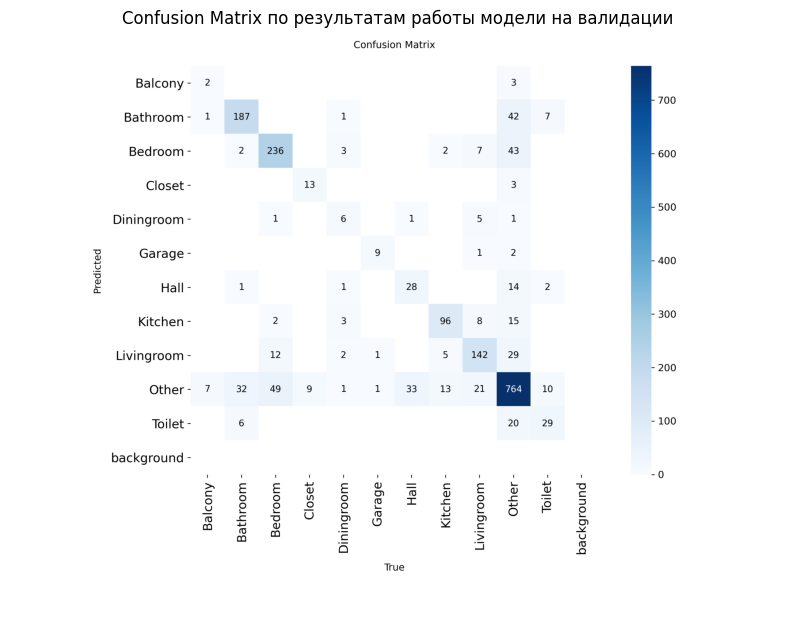

In [16]:
img = mpimg.imread(
    '/kaggle/working/runs/classify/train2/confusion_matrix.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title('Confusion Matrix по результатам работы модели на валидации')
plt.show()

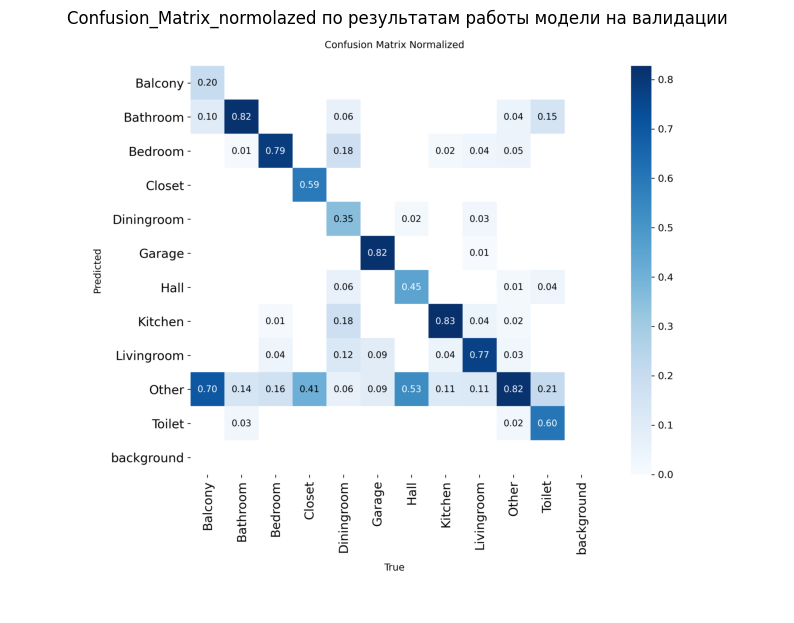

In [17]:
img_2 = mpimg.imread(
    '/kaggle/working/runs/classify/train2/confusion_matrix_normalized.png')
plt.figure(figsize=(10, 10))
plt.imshow(img_2)
plt.axis('off')
plt.title('Confusion_Matrix_normolazed по результатам работы модели на валидации')
plt.show()

## Предсказания класса помещения


image 1/1 /kaggle/working/estima-rooms/test/Kitchen/31878870_jpg.rf.de3c763f8897e79870509d71c7fda0fe_1.jpg: 224x224 Kitchen 0.45, Livingroom 0.31, Other 0.18, Bedroom 0.04, Bathroom 0.01, 4.4ms
Speed: 4.0ms preprocess, 4.4ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


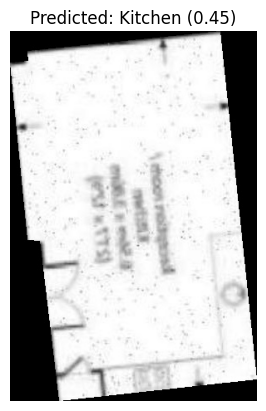

In [26]:
img_path='/kaggle/working/estima-rooms/test/Kitchen/31878870_jpg.rf.de3c763f8897e79870509d71c7fda0fe_1.jpg'
results_1=model(img_path)

pred_class = results_1[0].probs.top1
pred_conf = results_1[0].probs.top1conf.item()
class_name = model.names[pred_class]

img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {class_name} ({pred_conf:.2f})")
plt.show()


image 1/1 /kaggle/working/estima-rooms/test/Bedroom/105_png_jpg.rf.789fc9f78974f5f24776067876025797_0.jpg: 224x224 Other 0.58, Bedroom 0.42, Bathroom 0.00, Hall 0.00, Closet 0.00, 4.9ms
Speed: 2.8ms preprocess, 4.9ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


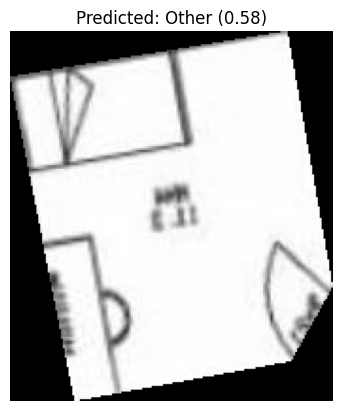

In [27]:
img_path='/kaggle/working/estima-rooms/test/Bedroom/105_png_jpg.rf.789fc9f78974f5f24776067876025797_0.jpg'
results_2=model(img_path)

pred_class = results_2[0].probs.top1
pred_conf = results_2[0].probs.top1conf.item()
class_name = model.names[pred_class]

img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {class_name} ({pred_conf:.2f})")
plt.show()